In [1]:
import pandas as pd
import numpy as np
import glob
import soundfile
import os
import sys

import librosa
import librosa.display
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [2]:
Dataset = "C:\\Users\\Dolly He\\Downloads\\3rd year project\\RAVDESS\\audio_speech_actors_01-24\\"

In [3]:
DirectoryList = os.listdir(Dataset)
fileEmotion = []
filePath = []
for dir in DirectoryList:
    actor = os.listdir(Dataset +  dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        fileEmotion.append(int(part[2]))
        filePath.append(Dataset + dir + '/' + file)
emotion_df = pd.DataFrame(fileEmotion, columns=['Emotions'])
path_df = pd.DataFrame(filePath, columns=['Path'])
Dataset_df = pd.concat([emotion_df, path_df], axis=1)

In [4]:
Dataset_df.Emotions.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}, inplace=True)
Dataset_df.head()

,Emotions,Path
0,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
1,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
2,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
3,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
4,calm,C:\Users\Dolly He\Downloads\3rd year project\R...


In [5]:
dataPath = pd.concat([Dataset_df], axis=0)
dataPath.to_csv("data_path.csv", index=False)
dataPath.head()

,Emotions,Path
0,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
1,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
2,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
3,neutral,C:\Users\Dolly He\Downloads\3rd year project\R...
4,calm,C:\Users\Dolly He\Downloads\3rd year project\R...


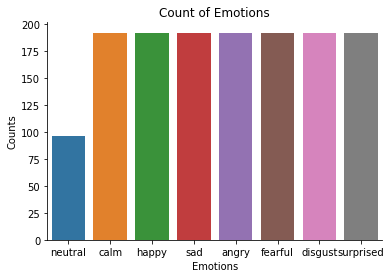

In [6]:
# Count of emotions
sb.countplot(dataPath.Emotions)
plt.ylabel('Counts')
plt.xlabel('Emotions')
plt.title('Count of Emotions')
sb.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
def createWaveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [8]:
def createSpectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

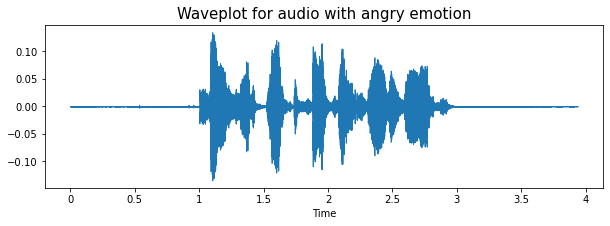

C:\Users\Dolly He\Downloads\3rd year project\RAVDESS\audio_speech_actors_01-24\Actor_01/03-01-05-01-01-02-01.wav


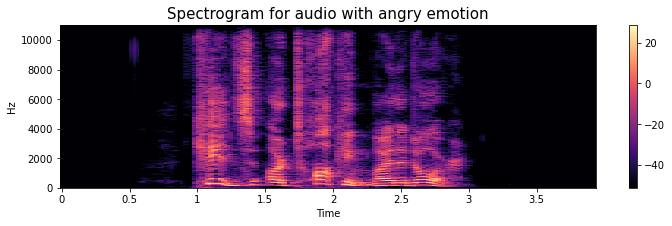

In [9]:
emotion = 'angry'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, samplingRate = librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
print(path)
#Audio(path)

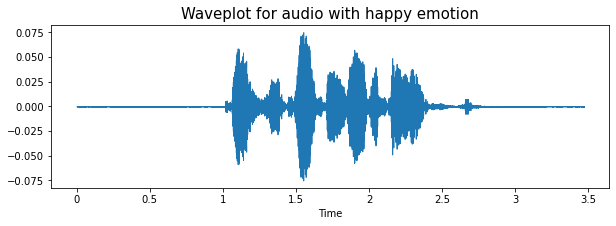

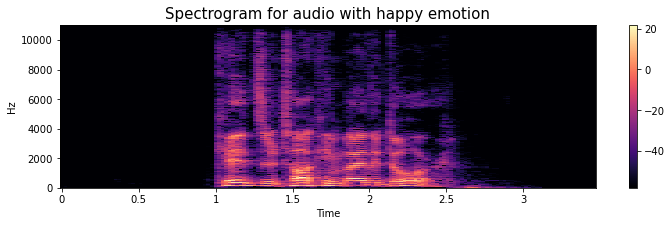

In [10]:
emotion = 'happy'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, samplingRate = librosa.load(path)
createWaveplot(data, samplingRate, emotion)
createSpectrogram(data, samplingRate, emotion)
#Audio(path)

In [11]:
def noise(data):
    noiseAmp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noiseAmp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shiftRange = int(np.random.normal(-5, 5)*1000)
    return np.roll(data, shiftRange)
    
def pitch(data, samplingRate, pitchFactor=0.7):
    return librosa.effects.pitch_shift(data, samplingRate, pitchFactor)

In [12]:
path = np.array(dataPath.Path)[1]
data, sample_rate = librosa.load(path)

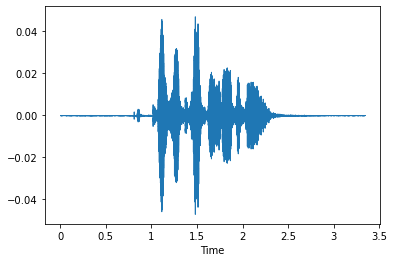

In [13]:
# Single audio
plt.figure()
librosa.display.waveshow(y=data, sr=sample_rate)
#Audio(path)

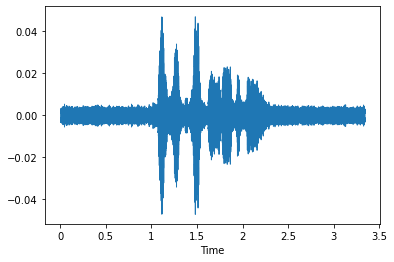

In [14]:
# Noise injection
x = noise(data)
plt.figure()
librosa.display.waveshow(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

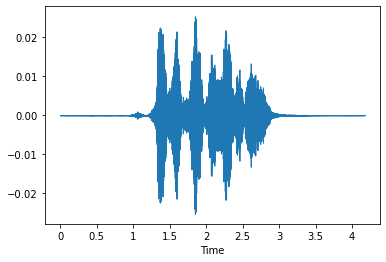

In [15]:
# Stretching
x = stretch(data)
plt.figure()
librosa.display.waveshow(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

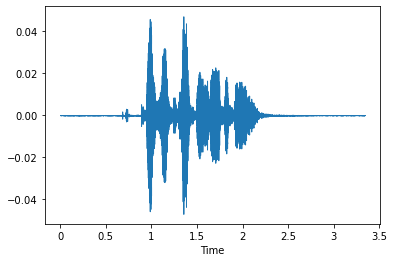

In [16]:
# Shifting
x = shift(data)
plt.figure()
librosa.display.waveshow(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

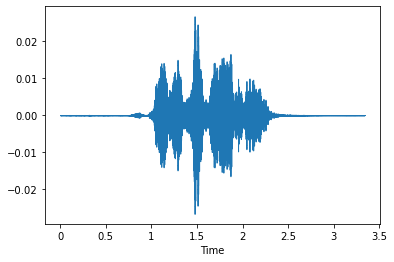

In [17]:
# Pitch
x = pitch(data, sample_rate)
plt.figure()
librosa.display.waveshow(y=x, sr=sample_rate)
#Audio(x, rate=sample_rate)

In [18]:

def extract_features(fileName, stft, zcr, rms, mfcc, chroma, mel):
    with soundfile.SoundFile(fileName) as soundFile:
        X = soundFile.read(dtype="float32")
        sample_rate = soundFile.samplerate
        result = np.array([])
        
        if stft:
            stft = np.abs(librosa.stft(X))
            result = np.array([])
        if zcr:
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
            result=np.hstack((result, zcr)) # stacking horizontally
        if mfcc:
            mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfcc))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if rms:
            rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
            result = np.hstack((result, rms)) # stacking horizontally
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
            
    return result

In [19]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprised'
}
#Observed_Emotions = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad'] #78.71%
#Observed_Emotions = ['angry', 'calm', 'happy'] #88.70%
Observed_Emotions = ['angry', 'happy', 'neutral'] #91.67%

#Observed_Emotions = ['calm', 'happy', 'sad'] #80.87%
#Observed_Emotions = ['neutral', 'happy', 'sad'] #86.46%

In [20]:
def load_data(test_size = 0.2):
    x, y = [], []
    for file in glob.glob("C:\\Users\\Dolly He\\Downloads\\3rd year project\\RAVDESS\\Actor_*\\*.wav"):
        fileName = os.path.basename(file)
        emotion_1 = emotions[fileName.split("-")[2]]
        if emotion_1 not in Observed_Emotions:
            continue
        feature = extract_features(file, stft=True, zcr=True, mfcc=True, chroma=True, rms=True, mel=True)
        x.append(feature)
        y.append(emotion_1)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [21]:
# pip install pydub
from pydub import AudioSegment

In [22]:
# splitting dataset
X_train, X_test, y_train, y_test = load_data(test_size = 0.2)

In [23]:
# Getting the shape of the training and testing datasets
print((X_train.shape[0], X_test.shape[0]))

(383, 96)


In [24]:
# Getting the number of features extracted
print(f'No.of features extracted: {X_train.shape[1]}')

No.of features extracted: 182


In [25]:
def print_confusion_matrix(y_test, y_pred):
    mat = metrics.confusion_matrix(y_test, y_pred)
    sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=Observed_Emotions, yticklabels=Observed_Emotions,)
    plt.xlabel('Actual Emotion')
    plt.ylabel('Predicted Emotion')
    plt.show()

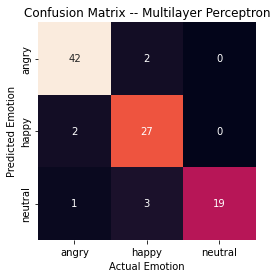

              precision    recall  f1-score   support

       angry       0.95      0.93      0.94        45
       happy       0.93      0.84      0.89        32
     neutral       0.83      1.00      0.90        19

    accuracy                           0.92        96
   macro avg       0.90      0.93      0.91        96
weighted avg       0.92      0.92      0.92        96

Accuracy: 91.67%


In [26]:
# Multilayer Perceptron ---- model = MLPClassifer
model = MLPClassifier(hidden_layer_sizes = (400, ),
                      activation = 'tanh',
                      solver = 'adam',
                      alpha = 0.01,
                      batch_size = 256, 
                      epsilon = 1e-8, 
                      learning_rate = 'adaptive',
                      max_iter = 600)

# Training the model
model.fit(X_train, y_train)

# Predicting for the test set
y_pred = model.predict(X_test)

# Confusion Matrix
plt.title('Confusion Matrix -- Multilayer Perceptron')
print_confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Calculating the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# Printing the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))